In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import svd
from scipy import interpolate 
import os

# llops imports
import llops as yp
import llops.simulation as sim

# Comptic imports
import comptic

# DPC analysis function
import pydpc

# Set backend and dtype for llops
yp.setDefaultBackend('numpy')
yp.setDefaultDatatype('float32')

# Directory to save figures
output_dir = os.path.expanduser('~/Desktop')

# Define Object

<IPython.core.display.Javascript object>


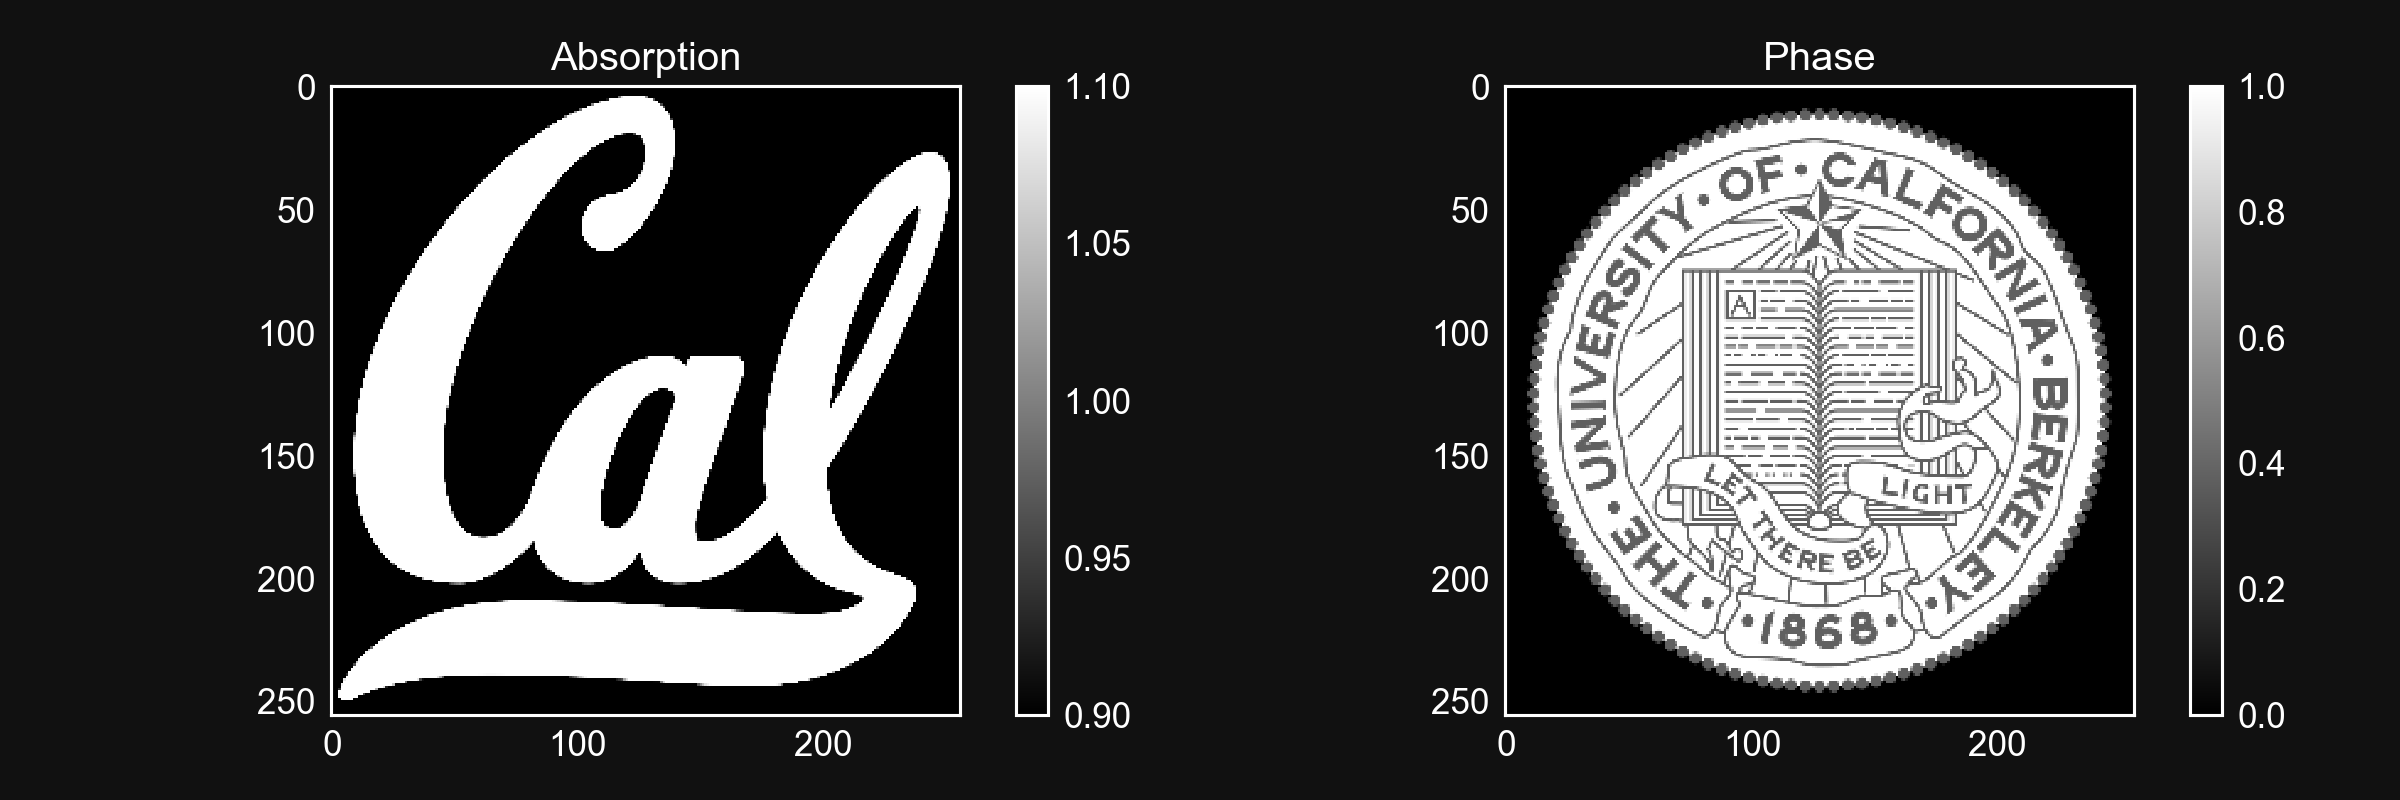

In [2]:
# Define object shape
object_shape = (256, 256)
# object_shape = (16, 16)

# Define complex object (field)
field = sim.ucb(object_shape)

# Get amplitude and phase
amp, phase = np.abs(field), np.angle(field)

# Plot
plt.figure()
plt.subplot(121)
plt.imshow(np.abs(field), cmap = 'gray')
plt.title('Absorption')
plt.colorbar()
plt.subplot(122)
plt.imshow(np.angle(field), cmap = 'gray')
plt.title('Phase')
plt.colorbar()
plt.tight_layout()

## Get System Parameters 

In [3]:
led_positions = comptic.ledarray.getPositionsNa('quasi-dome')

# Get remaining system parameters
system_parameters = pydpc.getDefaultSystemParams(system_magnification=2,
                                             illumination_source_position_list_na=led_positions)

# Defining a Source Using LED Positions

## Generate DPC Source Positions

<IPython.core.display.Javascript object>


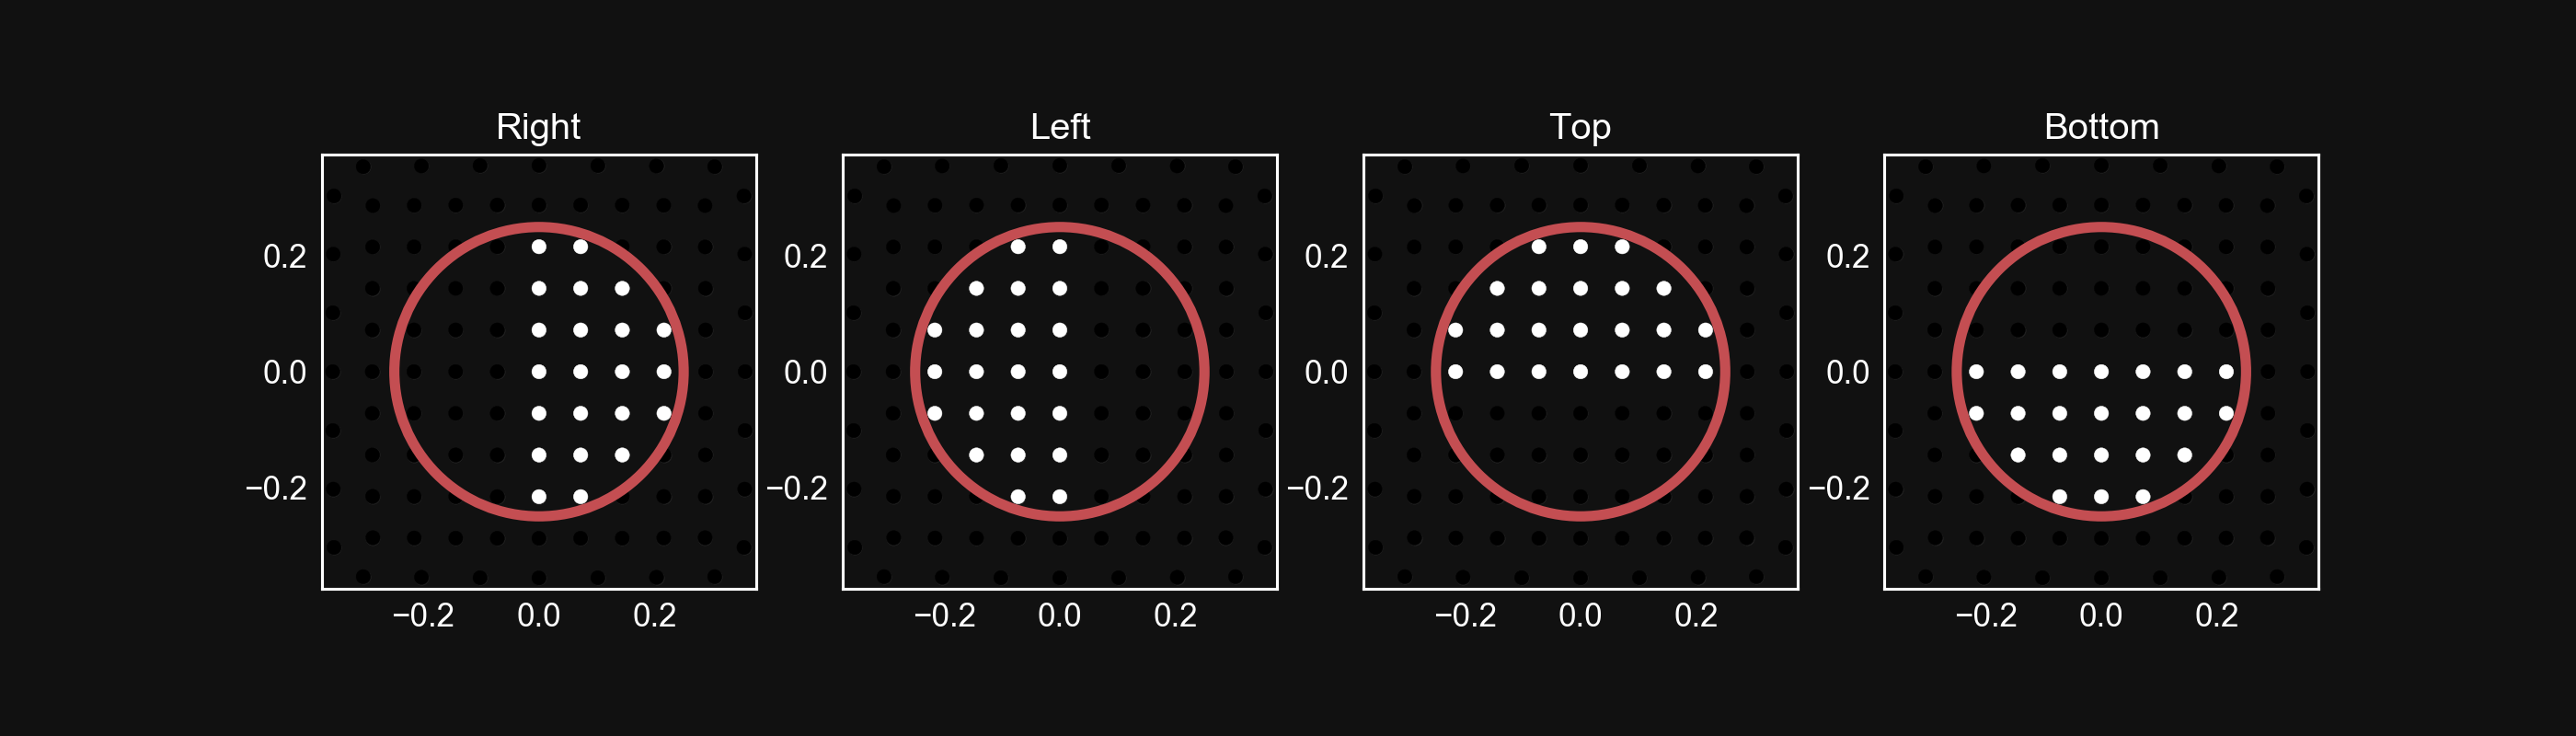

In [54]:
# Generate LED patterns
source_names = ['Right', 'Left', 'Top', 'Bottom']
dpc_led_pattern_list = pydpc.genDpcSourcePositionList(dpc_type_list=source_names, **system_parameters)

# Show patterns
pydpc.plotSourcePositionList(dpc_led_pattern_list, labels=source_names, **system_parameters)

## Show WOTFs

<IPython.core.display.Javascript object>


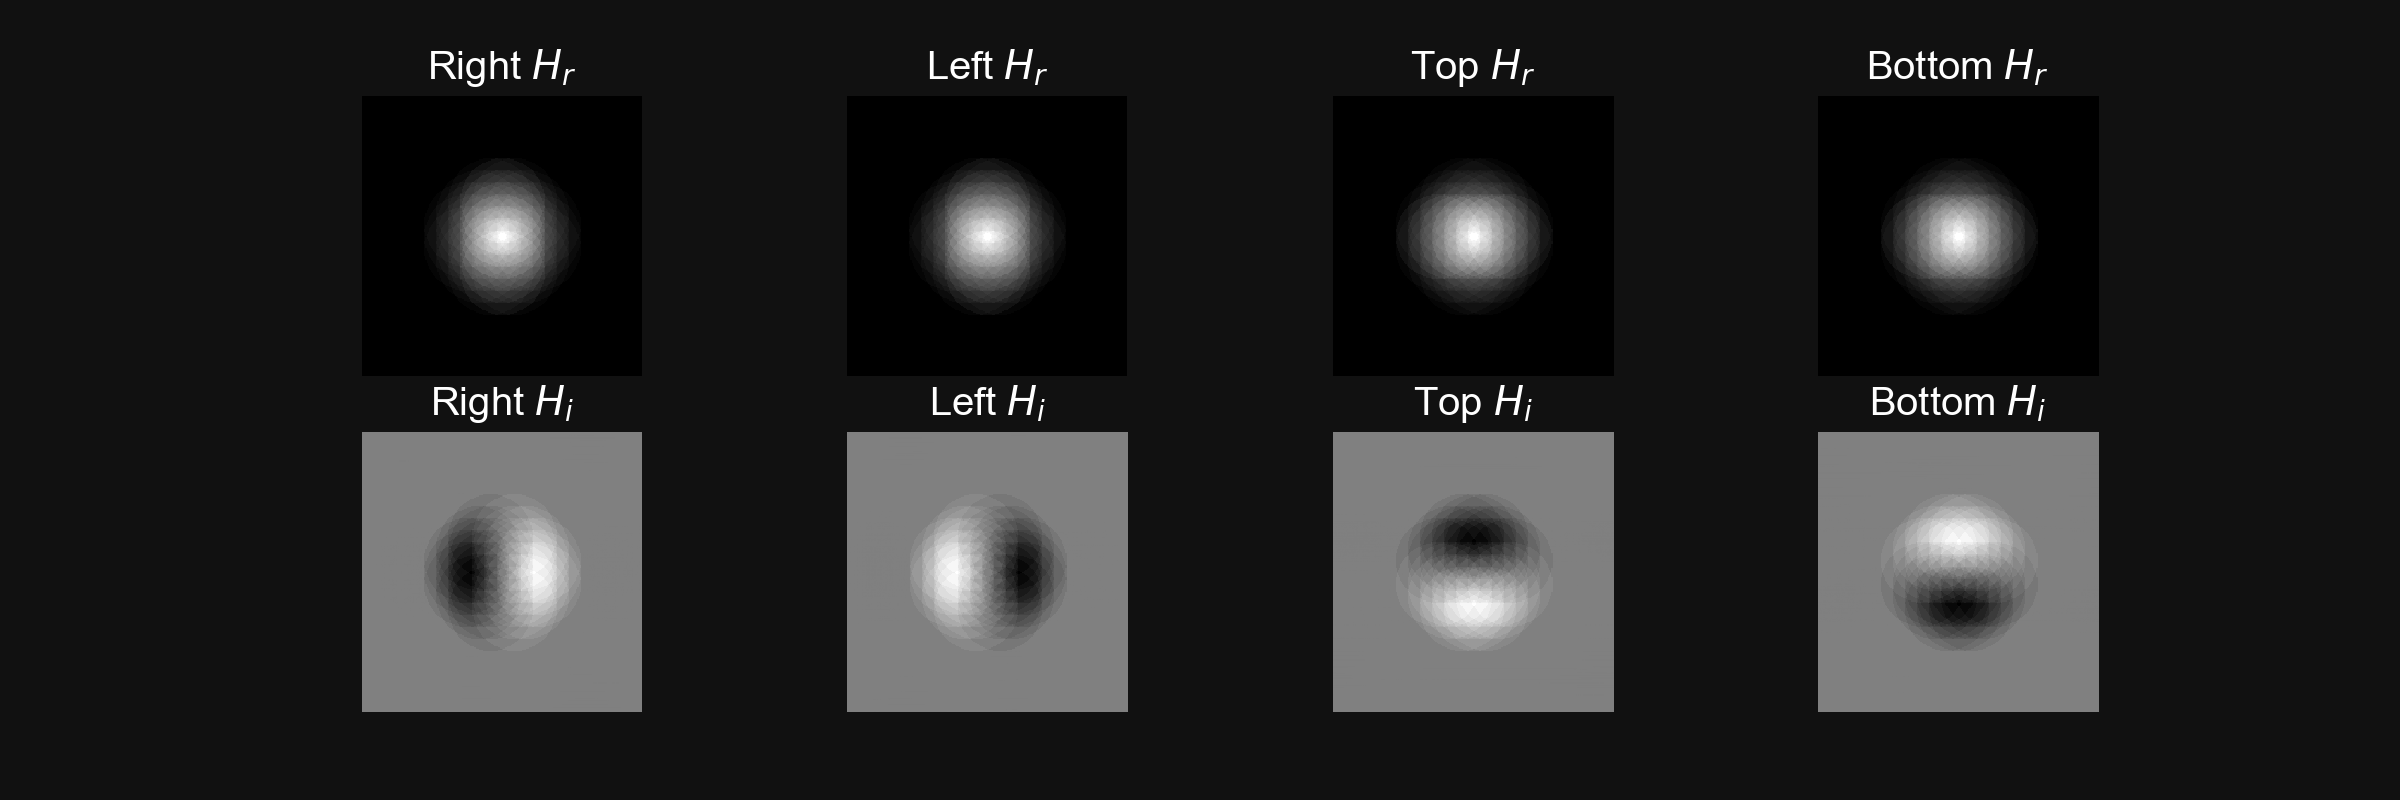

In [55]:
# Generate corresponding WOTFs
Hr_list, Hi_list = pydpc.genWotfsFromSourcePositionList(object_shape, dpc_led_pattern_list, **system_parameters )

# Show WOTFs
pydpc.plotWotfList(Hr_list, Hi_list, labels=source_names)

## Generate Nonlinear Measurements from Source Positions

<IPython.core.display.Javascript object>


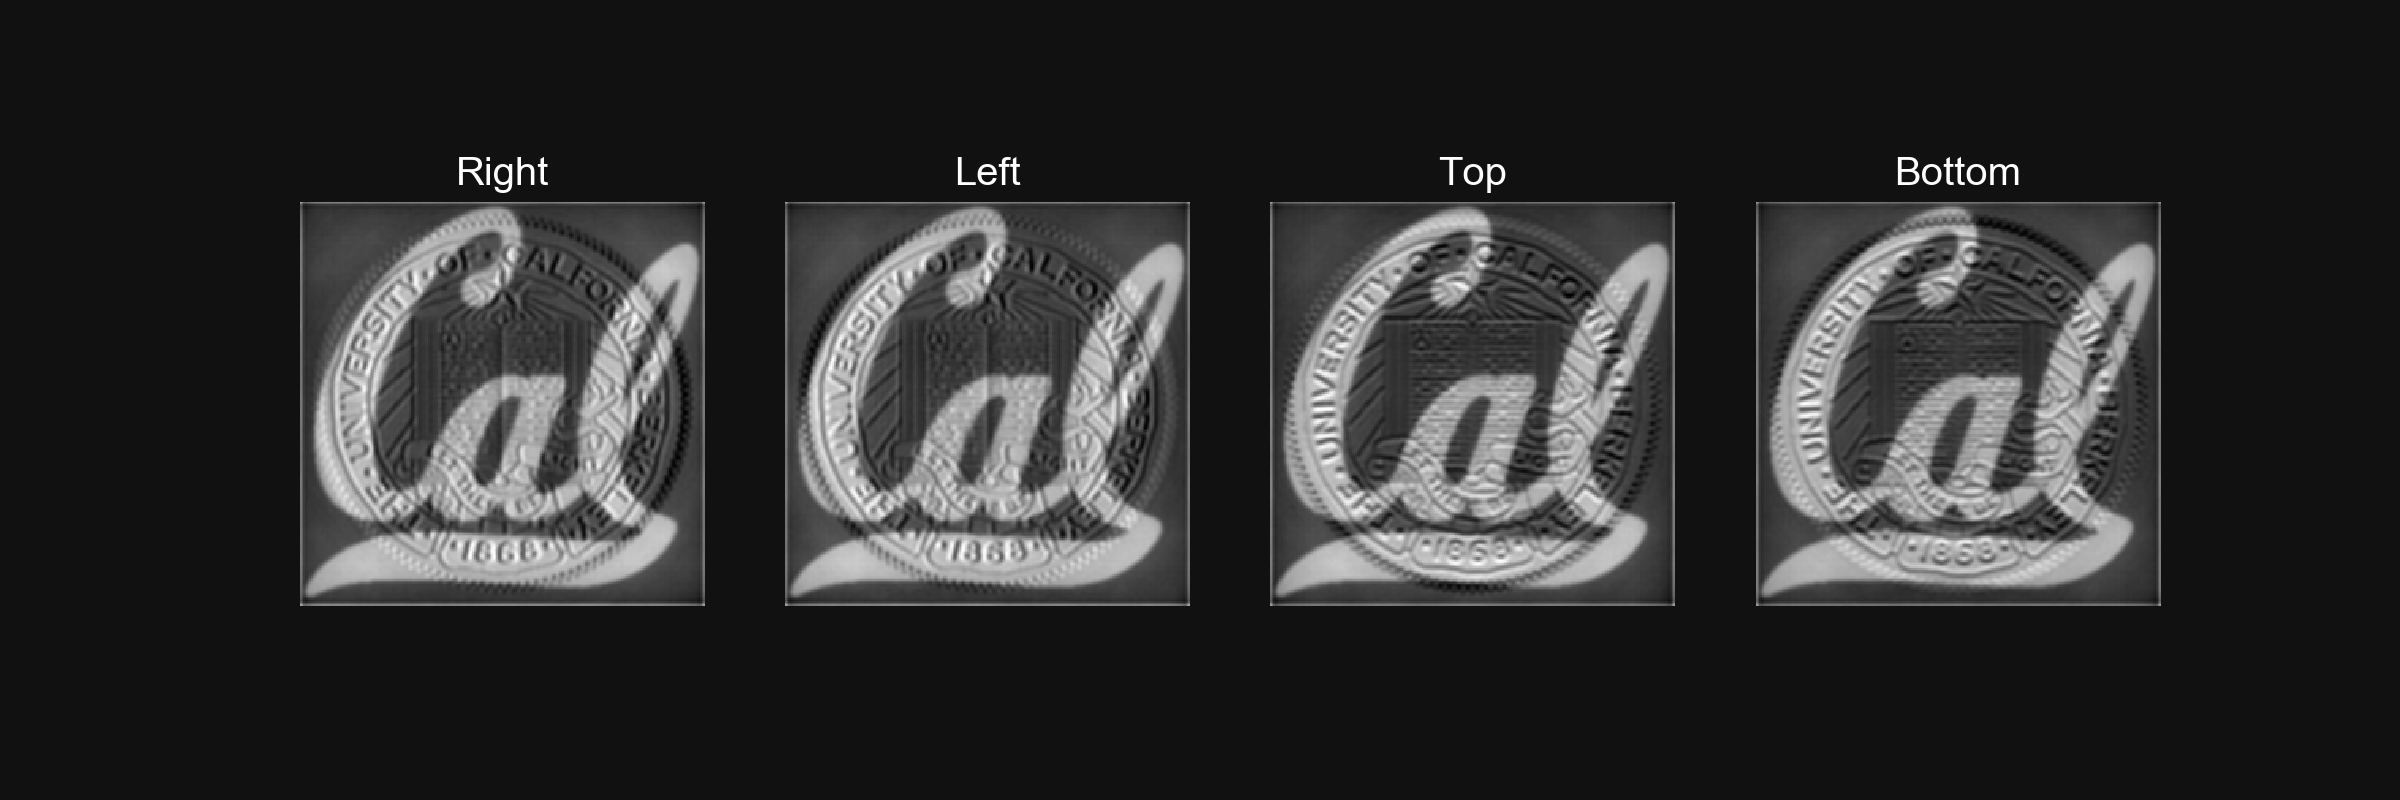

In [56]:
# Generate Intensities
measurement_list = [pydpc.genMeasurementNonLinear(field, dpc_pattern, **system_parameters) for dpc_pattern in dpc_led_pattern_list]

# Show result
yp.listPlotFlat(measurement_list, source_names)

## Generate Linear Measurements from Source Positions

<IPython.core.display.Javascript object>


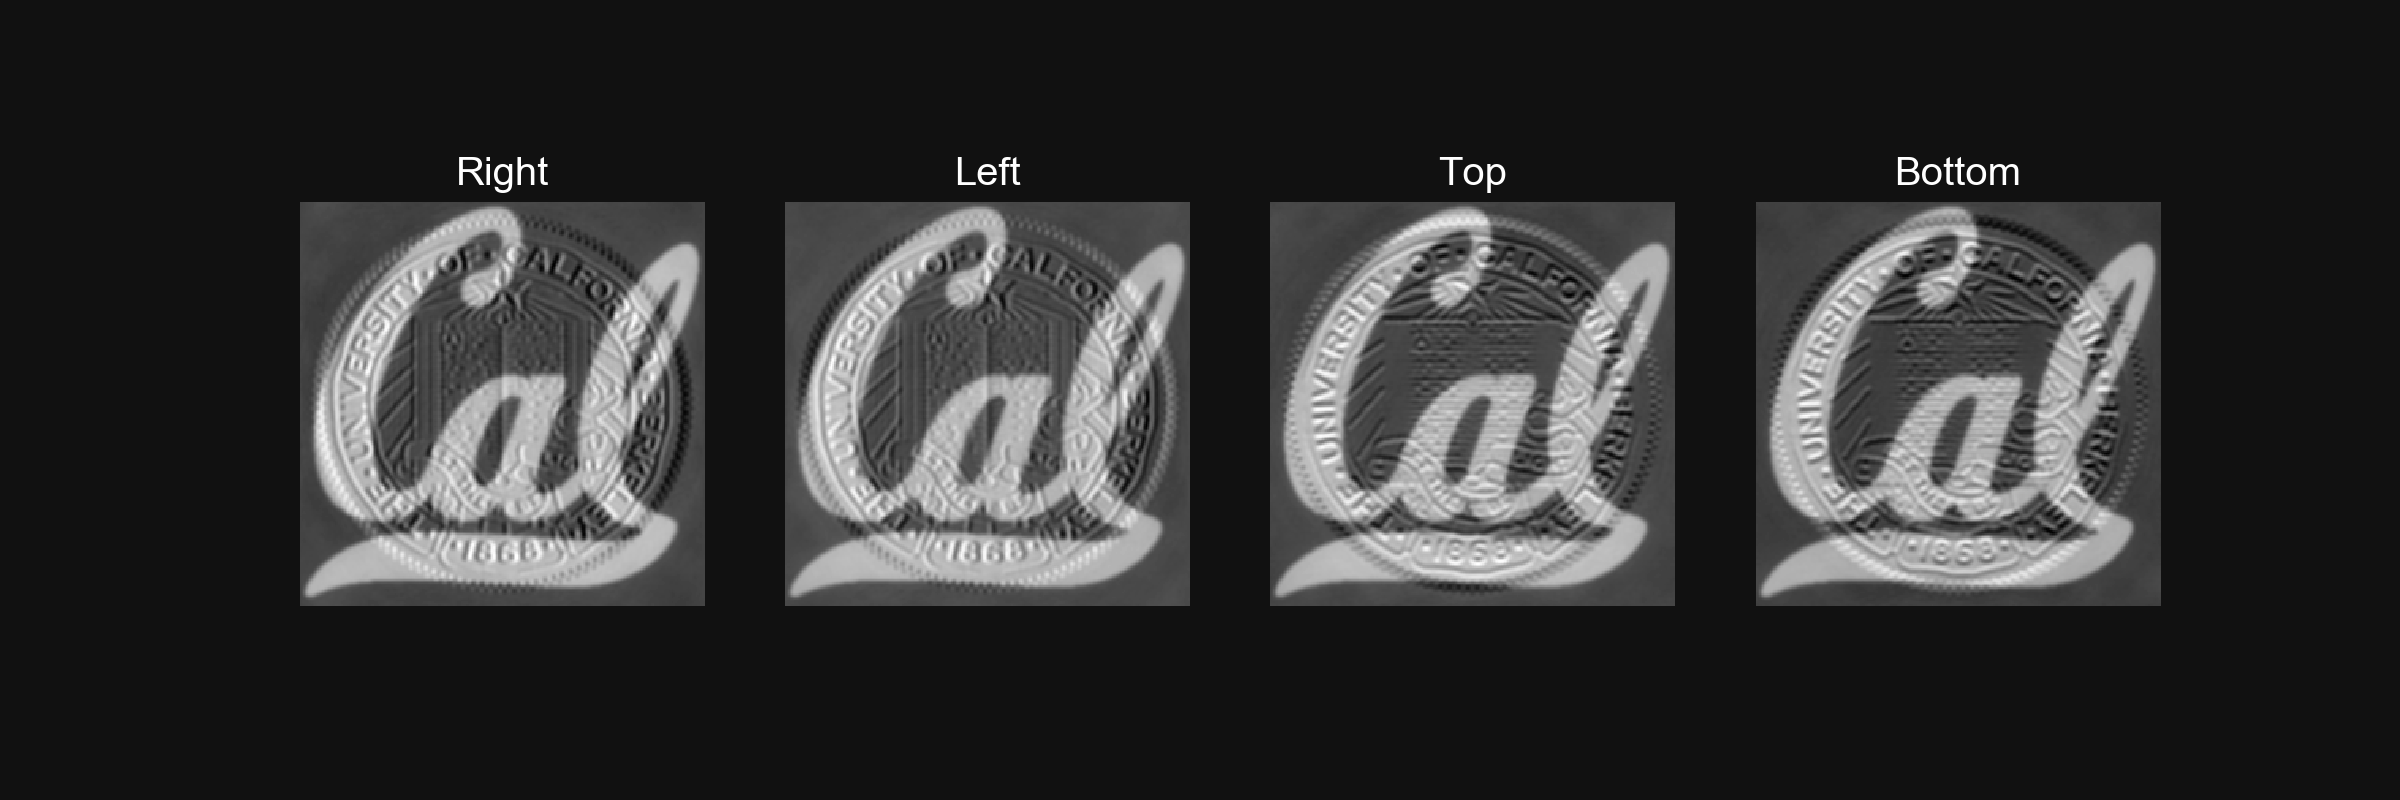

In [57]:
## Generate DPC patterns
intensity_list = pydpc.genMeasurementsLinear(field, dpc_led_pattern_list, **system_parameters)

# Print intensity
yp.listPlotFlat(intensity_list, source_names)

# Using a Continuous Source

<IPython.core.display.Javascript object>


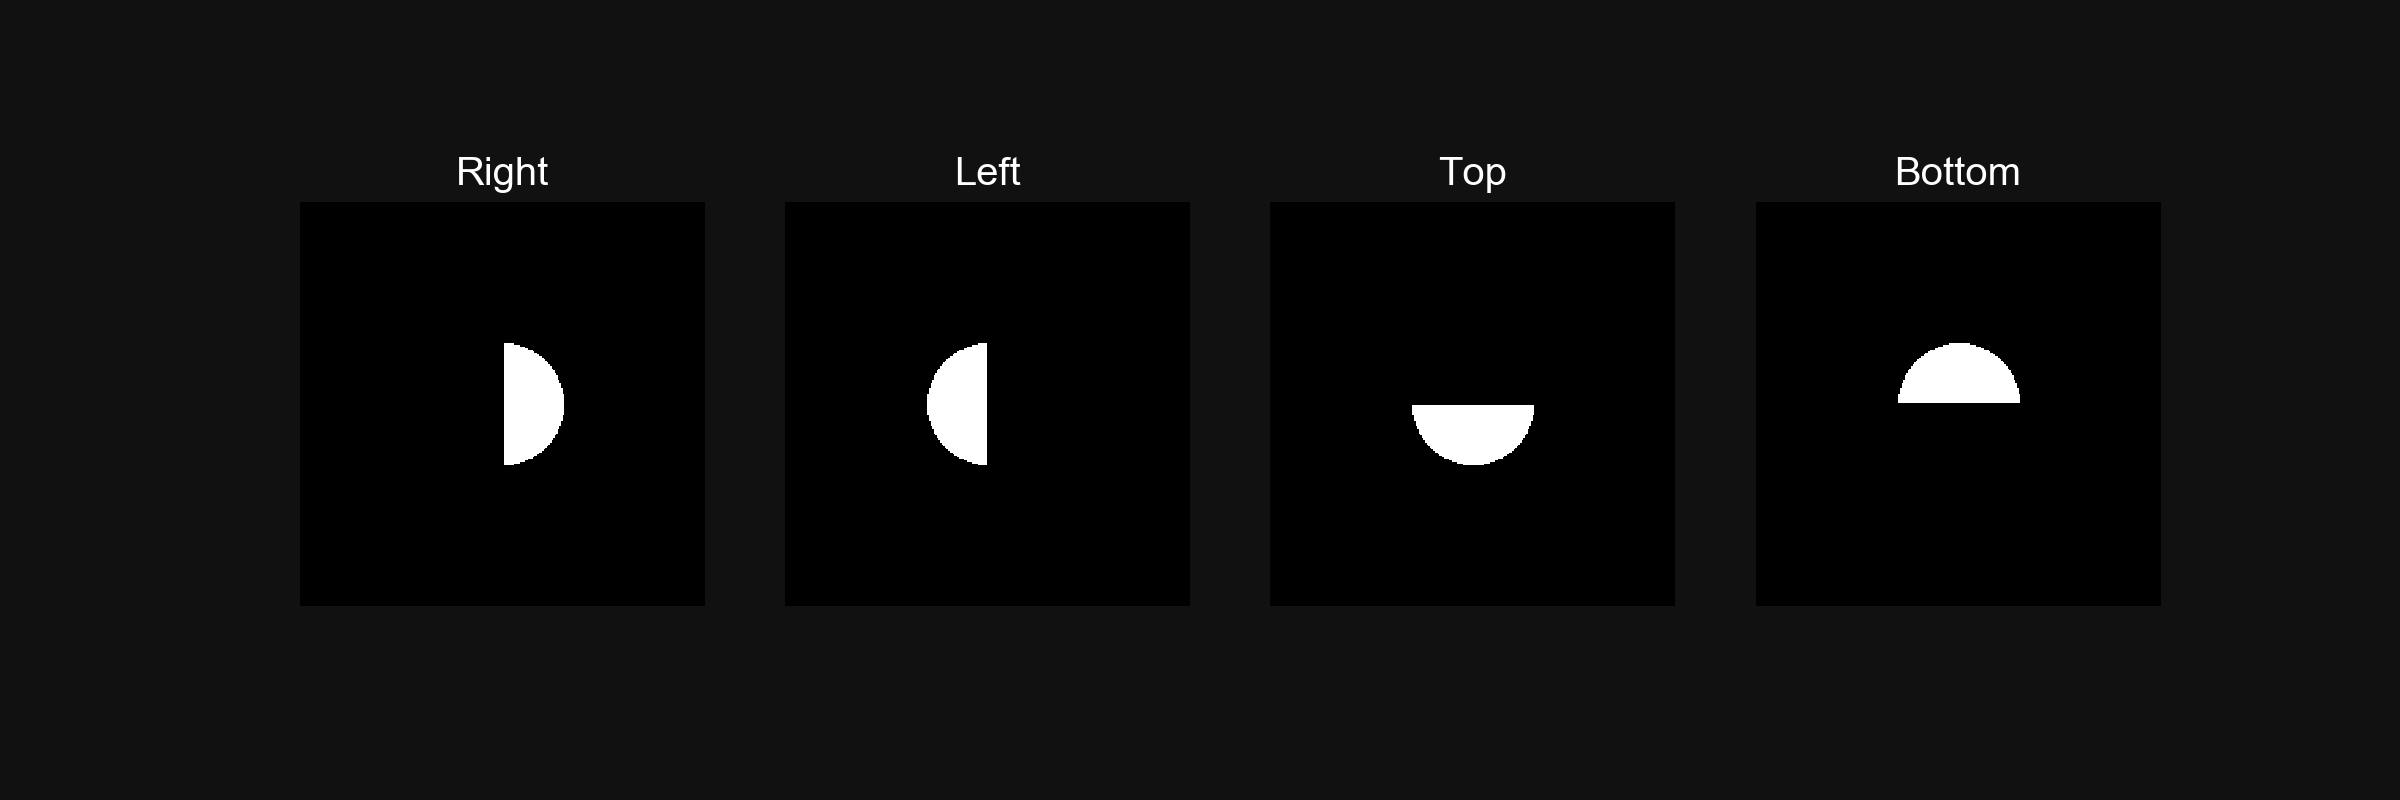

In [59]:
# Generate LED patterns
source_names = ['Right', 'Left', 'Top', 'Bottom']
dpc_source_list = pydpc.genDpcSourceList(object_shape, dpc_type_list=source_names, **system_parameters)

# Show patterns
yp.listPlotFlat(dpc_source_list, source_names)

## Generate WOTFs

In [60]:
# Generate corresponding WOTFs
Hr_list, Hi_list = pydpc.genWotfs(dpc_source_list, dpc_led_pattern_list, **system_parameters )

# Show WOTFs
pydpc.plotWotfList(Hr_list, Hi_list, labels=source_names)

ValueError: operands could not be broadcast together with shapes (4,581) (4,256,256) 

# Calculate Estimated SNR of Measurements

In [ ]:
# Define illuminance at sample per LED
per_led_illuminance = 1000

# Determine total illuminance for each pattern
total_pattern_illuminance = [per_led_illuminance * yp.sum(dpc_pattern) for dpc_pattern in dpc_led_pattern_list]

# Determine photon pixel rate
photon_pixel_rate_list = [pydpc.analysis.illuminanceToPhotonPixelRate(illuminance, **system_parameters) for illuminance in total_pattern_illuminance]

# Define Exposure time
exposure_time = 0.01

# Determine measurement SNR
snr_list = [pydpc.analysis.photonPixelRateToSnr(photon_pixel_rate, exposure_time, **system_parameters) for photon_pixel_rate in photon_pixel_rate_list]
print(snr_list)

## Add SNR to Measurements

In [ ]:
# Add noise to measurements
measurement_list_noisy = [comptic.noise.add(measurement, type='gaussian', snr=snr) for measurement, snr in zip(measurement_list, snr_list)]

# Show noisy measurements
yp.listPlotFlat(measurement_list_noisy)

## Generate WOTFs from LED Positions

In [ ]:
# Generate source list
source_list = pydpc.genDpcSourceList(object_shape, ['right', 'left', 'top', 'bottom'], **system_parameters)

# Generate Hr and Hi from source list
Hr_list, Hi_list = pydpc.wotfsFromSourceList(source_list, **system_parameters)

# Show WOTFs
yp.listPlotFlat(Hr_list + [yp.imag(Hi) for Hi in Hi_list], source_names + source_names, max_width=4)

## Generate WOTFs from Source Position List

In [ ]:
# Generate Hr and Hi from source list
Hr_list, Hi_list = pydpc.wotfsFromSourcePositionList(object_shape, dpc_led_pattern_list, **system_parameters)

# Show WOTFs
yp.listPlotFlat(Hr_list + [yp.imag(Hi) for Hi in Hi_list], source_names + source_names, max_width=4)

## Calculate WOTF Support

In [ ]:
# Define mask size
minimum_na = 0.05
maximum_na = system_parameters['objective_numerical_aperture'] * 1.5

# Generate mask
support = pydpc.analysis.supportMask(object_shape, min_na=minimum_na, max_na=maximum_na, **system_parameters)

# Plot result
plt.figure()
plt.imshow(support)

## Normalize Measurements

In [ ]:
measurement_list_normalized = [measurement / yp.mean(measurement) - 1.0 for measurement in measurement_list_noisy]

## Perform DPC Inversion

In [ ]:
field_recovered = pydpc.invert(measurement_list_normalized, Hr_list, Hi_list, reg_imag=1e-8, reg_real=1e-8)

plt.figure()
plt.subplot(121)
plt.imshow(yp.real(field_recovered))
plt.subplot(122)
plt.imshow(yp.imag(field_recovered))

# Calculate DNF of WOTF patterns

In [ ]:
# Calculate singular values and masl
sigma_squared = pydpc.analysis.singularValuesFromWotfList(Hr_list, Hi_list, support=support)

# Calculate DNF from Hu and Hp
f = pydpc.analysis.dnfFromWotfList(Hr_list, Hi_list, support=support)
print(f)

# Calculate DNF directly from source patterns
f = pydpc.analysis.dnfFromSourcePositionList(dpc_led_pattern_list, object_shape, support=support,**system_parameters)
print(f)

# Check DNF Calculation

In [ ]:
# Generate rasterized sources
source_list = pydpc.genDpcSourceList((16,16), source_names, minimum_na=0.15, **system_parameters)

# Generate Hr and Hi
Hr_list, Hi_list = pydpc.wotfsFromSourceList(source_list, **system_parameters)

# Calculate singular values using three different ways
sigma_direct = pydpc.analysis.singularValuesFromWotfList(Hr_list, Hi_list)
sigma_svd = pydpc.analysis.singularValuesFromWotfList(Hr_list, Hi_list, method='svd')
sigma_eig = pydpc.analysis.singularValuesFromWotfList(Hr_list, Hi_list, method='eig')

plt.figure()
plt.plot(sigma_direct)
plt.plot(sigma_svd)
plt.plot(sigma_eig)

# Check That DNF is Valid for DPC (Linear Model)

In [ ]:
# Generate DPC patterns
dpc_pattern_list = pydpc.genDpcSourcePositionList(**system_parameters)

# Generate DPC patterns
intensity_list = pydpc.genMeasurementsLinear(field, dpc_pattern_list, **system_parameters)

# Add measurement noise
measurement_snr = 200
intensity_list_noisy = [comptic.noise.add(intensity, snr=measurement_snr) for intensity in intensity_list]

# Recover field
Hr_list, Hi_list = pydpc.wotfsFromSourcePositionList(object_shape, dpc_pattern_list, **system_parameters)
field_recovered = pydpc.invert(intensity_list_noisy, Hr_list, Hi_list, reg_real=1e-8, reg_imag=1e-8)

# Calculate DNF
dnf = pydpc.analysis.dnfFromSourcePositionList(dpc_led_pattern_list, object_shape, **system_parameters)

# Calculate SNR for amplitude and phase
snr_recovered_amp = yp.mean(yp.real(field_recovered)) / yp.std(yp.real(field_recovered)[:10, :10])
snr_recovered_phase = yp.mean(yp.imag(field_recovered)) / yp.std(yp.imag(field_recovered)[:10, :10])

print(measurement_snr)
print(dnf* snr_recovered_amp)
print(dnf * snr_recovered_phase)

## Generate Random LED Patterns

In [ ]:
# This supports method = 'grayscale' or 'binary' and pattern_type  = 'full', 'left', 'right', 'top', 'bottom'
pattern = pydpc.analysis.genRandomIlluminationPattern(method='binary', pattern_type='right', minimum_numerical_aperture=0, **system_parameters)

# Generate four DPC patterns
pattern_list = [pydpc.analysis.genRandomIlluminationPattern(method='binary', pattern_type=name, minimum_numerical_aperture=0, **system_parameters) for name in source_names]

# Plot LED patterns
pydpc.plotSourcePositionList(pattern_list, **system_parameters)

# Plot WOTFs
Hr_list, Hi_list = pydpc.wotfsFromSourcePositionList(object_shape, pattern_list, **system_parameters)

# Show WOTFs
pydpc.plotWotfList(Hr_list, Hi_list)

# Perform Source Optimization Using Random Search
Not that interesting...

In [ ]:
# # Define mask size
# minimum_na = 0.05
# maximum_na = system_parameters['objective_numerical_aperture'] * 1.5

# f, pattern = analysis.optimizeSourceRandom((50,50), iteraton_count=100, minimum_na=minimum_na, maximum_na=maximum_na, gamma=2, **system_parameters)
# analysis.plotLedPatternList(pattern, **system_parameters)
# print(f)

# Sweep Inner NA and Calculate Expected SNR

In [ ]:
# Calculate support
support = pydpc.analysis.supportMask(object_shape, min_na=0.01, max_na=0.25, **system_parameters)

# Source Illuminance
per_led_illuminance = 1000

# Camera exposure time
exposure_time = 1e-4

# Define range to sweep inner NA
inner_na_sweep = list(np.arange(0, 0.25, 0.01))
illuminance_sweep = list(range(1, 4000, 100))

# Generate DPC Types
dpc_type_list = ['top', 'bottom', 'left', 'right']

# Calculate expected SNR for each source
snr_list_na = []
for per_led_illuminance in yp.display.progressBar(illuminance_sweep, name='Illumination Intensity Value'):
    _snr_list = []
    for inner_na in inner_na_sweep:
        # Generate rasterized sources
        source_list = pydpc.genDpcSourceList(object_shape, dpc_type_list, illumination_inner_na=inner_na, **system_parameters)

        # Calculate SNR
        snr = pydpc.analysis.calcSnrFromDpcSourceList(source_list, exposure_time=exposure_time, support=support, per_led_illuminance=per_led_illuminance, **system_parameters)

        # Append
        _snr_list.append(snr)
    snr_list_na.append(_snr_list)

## Generate Figure

In [ ]:
# Highlight best width
spline_tuples = []
for illuminance_index, _snr in enumerate(snr_list_na):
    na_index = yp.argmax(_snr)[0]
    spline_tuples.append((illuminance_sweep[illuminance_index],
                         inner_na_sweep[na_index]))
    

nodes = np.asarray(spline_tuples)[0:-1:1]
fs = 20
x = nodes[:,1]
y = nodes[:,0]

tck,u     = interpolate.splprep( [x,y] ,s = 0 )
xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

plt.style.reload_library()
with plt.style.context('publication'):
    # Make figures
    plt.figure(figsize=(8, 12))
    plt.subplot(211)
    plt.imshow(snr_list_na, extent=[min(inner_na_sweep), max(inner_na_sweep), min(illuminance_sweep), max(illuminance_sweep)], cmap='viridis')
    plt.plot(xnew ,ynew , linewidth=3, c='w')
    plt.axis('tight')
    plt.xlabel('Inner NA Cutoff', fontsize=fs)
    plt.ylabel('Illuminance', fontsize=fs)
    plt.tight_layout()
    plt.xlim((min(inner_na_sweep), max(inner_na_sweep)))
    plt.ylim((min(illuminance_sweep), max(illuminance_sweep)))

    index_1 = 3
    index_2 = -11
    index_3 = -2
    
    plt.gca().tick_params(axis='both', which='major', labelsize=fs)
    plt.gca().tick_params(axis='both', which='minor', labelsize=fs)

    plt.subplot(212)
    plt.plot(inner_na_sweep, snr_list_na[index_1], label='%d lux' % (illuminance_sweep[index_1] - 1), linewidth=3)
    plt.plot(inner_na_sweep, snr_list_na[index_2], label='%d lux' % (illuminance_sweep[index_2] - 1), linewidth=3)
    plt.plot(inner_na_sweep, snr_list_na[index_3], label='%d lux' % (illuminance_sweep[index_3] - 1), linewidth=3)
    
    # Show maximum 
    max_index_1 = np.argmax(snr_list_na[index_1])
    max_index_2 = np.argmax(snr_list_na[index_2])
    max_index_3 = np.argmax(snr_list_na[index_3])
    
    plt.plot([inner_na_sweep[max_index_1]], [snr_list_na[index_1][max_index_1]], 'bD', markersize=10)
    plt.plot([inner_na_sweep[max_index_2]], [snr_list_na[index_2][max_index_2]], 'gD', markersize=10)
    plt.plot([inner_na_sweep[max_index_3]], [snr_list_na[index_3][max_index_3]], 'rD', markersize=10)
    
    plt.legend(loc='upper right', fontsize=fs)
    plt.xlabel('Inner NA Cutoff', fontsize=fs)
    plt.ylabel('Predicted SNR', fontsize=fs)
    plt.ylim((0, 35))
    
    plt.gca().tick_params(axis='both', which='major', labelsize=fs)
    plt.gca().tick_params(axis='both', which='minor', labelsize=fs)
    
    plt.tight_layout()
    
    # Save figure
    plt.savefig(os.path.join(output_dir, 'inner_na_vs_illuminance.pdf'))

## Save Avatars for Figure

In [ ]:
dpc_pattern_designs_2 = ['top', 'left']
dpc_pattern_designs = [('half', 'half', 'half', 'half', 'half', 'half')]
dpc_angles = np.arange(0,360, 360/6)

import copy
system_parameters_2 = copy.deepcopy(system_parameters)
system_parameters_2['system_magnification'] = 1

with plt.style.context('deblur'):
    plt.figure(figsize=(5,5))
    for dpc_pattern in dpc_pattern_designs_2:
        source = pydpc.genDpcSourceList(object_shape, dpc_pattern, illumination_inner_na=0, **system_parameters_2)
        plt.clf()
        plt.imshow(source)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'measurement_count_pattern_%s.pdf' % dpc_pattern))

    for angle in dpc_angles:
        source = pydpc.genDpcSourceList(object_shape, 'half', angle=angle, illumination_inner_na=0, **system_parameters_2)
        plt.clf()
        plt.imshow(source)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'angle_%d.pdf' % angle))

# Sweep Number of Measurements

In [ ]:
n = 3
angle_list = np.arange(0, 360, 360 / n)

source_list = []
for angle in angle_list:
    source_list += [pydpc.genDpcSourceList(object_shape, 'half', angle=angle, minimum_na=0, **system_parameters)]

# Compute SNR
snr = pydpc.analysis.calcSnrFromDpcSourceList(source_list, exposure_time=exposure_time, support=support, per_led_illuminance=1000, **system_parameters)

# print(snr)

dnf = pydpc.analysis.dnfFromSourceList(source_list, **system_parameters, support=support, eps=1e-5)
print(dnf)

In [ ]:
# Calculate support
support = pydpc.analysis.supportMask(object_shape, min_na=0.01, max_na=0.25, **system_parameters)

# Source Illuminance
per_led_illuminance = 1000

# Camera exposure time
exposure_time = 1e-4

# Define range to sweep inner NA
inner_na_sweep = list(np.arange(0, 0.25, 0.01))
measurement_count_sweep = list(range(1, 8))

dpc_type_list = ['top', 'bottom', 'left', 'right']
# dpc_type_list = [0, 90, 180]
# Calculate expected SNR for each source
snr_list, dnf_list = [], []
for per_led_illuminance in yp.display.progressBar(illuminance_sweep):
    _snr_list = []
    for measurement_count in measurement_count_sweep:
        
        # Instantiate source list
        source_list = []
        
        # Generate list of angles
        angle_list = np.arange(0, 360, 360 / measurement_count)
        
        # Generate sources
        for angle in angle_list:
            source_list += [pydpc.genDpcSourceList(object_shape, ['half'], angle=angle, minimum_na=0, **system_parameters)]
            
        # Ensure all sources have been generated
        assert len(source_list) == measurement_count
        
        # Calculate SNR
        snr = pydpc.analysis.calcSnrFromDpcSourceList(source_list, exposure_time=exposure_time, support=support, per_led_illuminance=per_led_illuminance, **system_parameters)

        # Append
        _snr_list.append(snr)
    snr_list.append(_snr_list)

## Generate Figure

In [ ]:
# Highlight best width
spline_tuples = []
for illuminance_index, _snr in enumerate(snr_list):
    na_index = yp.argmax(_snr)[0]
    spline_tuples.append((illuminance_sweep[illuminance_index],
                         measurement_count_sweep[na_index]))
    
    
nodes = np.asarray(spline_tuples)[0:-1:1]
fs = 20
x = nodes[:,1]
y = nodes[:,0]

tck,u     = interpolate.splprep( [x,y] ,s = 0 )
xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

plt.style.reload_library()
with plt.style.context('publication'):
    # Make figures
    plt.figure(figsize=(8,12))
    plt.subplot(211)
    plt.imshow(snr_list, extent=[min(measurement_count_sweep), max(measurement_count_sweep), min(illuminance_sweep), max(illuminance_sweep)], cmap='viridis')
    plt.plot(xnew ,ynew , linewidth=3, c='k')
    plt.axis('tight')
    plt.xlabel('Measurement Count', fontsize=fs)
    plt.ylabel('Illuminance', fontsize=fs)
    plt.tight_layout()
    plt.xlim((min(measurement_count_sweep), max(measurement_count_sweep)))
    plt.ylim((min(illuminance_sweep), max(illuminance_sweep)))

    index_1 = 3
    index_2 = -11
    index_3 = -2
    
    plt.gca().tick_params(axis='both', which='major', labelsize=fs)
    plt.gca().tick_params(axis='both', which='minor', labelsize=fs)

    plt.subplot(212)
    plt.plot(measurement_count_sweep, snr_list[index_1], label='%d lux' % (illuminance_sweep[index_1] - 1), linewidth=3)
    plt.plot([] + measurement_count_sweep, [] + (snr_list[index_1][-1] * np.sqrt(measurement_count_sweep)  / np.sqrt(measurement_count_sweep)[-1]).tolist(), 'b--', 
             label=None, linewidth=1) # '$\sqrt{\cdot}$ fit, %d Lux' % (illuminance_sweep[index_1] - 1)
    
    plt.plot(measurement_count_sweep, snr_list[index_2], label='%d lux' % (illuminance_sweep[index_2] - 1), linewidth=3)
    plt.plot([] + measurement_count_sweep, [] + (snr_list[index_2][-1] * np.sqrt(measurement_count_sweep)  / np.sqrt(measurement_count_sweep)[-1]).tolist(), 'g--', 
         label=None, linewidth=1) # '$\sqrt{\cdot}$ fit, %d Lux' % (illuminance_sweep[index_2] - 1)
    
    plt.plot(measurement_count_sweep, snr_list[index_3], label='%d lux' % (illuminance_sweep[index_3] - 1), linewidth=3)
    plt.plot([] + measurement_count_sweep, [] + (snr_list[index_3][-1] * np.sqrt(measurement_count_sweep)  / np.sqrt(measurement_count_sweep)[-1]).tolist(), 'r--', 
         label=None, linewidth=1) # '$\sqrt{\cdot}$ fit, %d Lux' % (illuminance_sweep[index_2] - 1)
    
    plt.legend(loc='upper left', fontsize=fs)
    plt.xlabel('Measurement Count', fontsize=fs)
    plt.ylabel('Predicted SNR', fontsize=fs)
    plt.tight_layout()
    plt.xlim((1,max(measurement_count_sweep)))
    plt.ylim((0, 25))
    
    plt.gca().tick_params(axis='both', which='major', labelsize=fs)
    plt.gca().tick_params(axis='both', which='minor', labelsize=fs)
    # Save figure
    plt.savefig(os.path.join(output_dir, 'measurement_count_vs_illuminance.pdf'))

## Generate Transfer Functions for Figure

In [ ]:
dpc_inner_na = [0.01, 0.05, 0.1, 0.15, 0.2, 0.24]

pupil = comptic.imaging.pupil(object_shape, **system_parameters)

plots = []
for inner_na in dpc_inner_na:
    source = [pydpc.genDpcSourceList(object_shape, 'left', illumination_inner_na=inner_na, **system_parameters)]
    Hr, Hi = pydpc.wotfsFromSourceList(source, pupil, **system_parameters_2)
    
    # Generate Cutlines
    cutline_Hr = np.real(Hr[object_shape[0] // 2, :]).copy()
    cutline_Hr /= np.max(cutline_Hr)
    cutline_Hi = np.imag(Hi[object_shape[0] // 2, :]).copy()
    cutline_Hi /= np.max(cutline_Hr)
    
    plots.append((source[0], Hr, cutline_Hr, Hi, cutline_Hi))

In [ ]:
with plt.style.context('deblur'):
    plt.figure(figsize=(5,5))

    for inner_na, plot_list in zip(dpc_inner_na, plots):

        # Plot source
        plt.clf()
        plt.imshow(np.abs(plot_list[0]))
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'inner_na_transfer_func_source_%.2f.pdf' % inner_na))

        # Plot Hr
        plt.clf()
        plt.imshow(np.real(plot_list[1]))
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'inner_na_transfer_func_hr_%.2f.pdf' % inner_na))

        # Plot Hi
        plt.clf()
        plt.imshow(np.imag(plot_list[3]))
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'inner_na_transfer_func_hi_%.2f.pdf' % inner_na))


    plt.figure(figsize=(5,1.5))
    # Cutline plots
    for inner_na, plot_list in zip(dpc_inner_na, plots):

        # Plot Hr cutline
        plt.clf()
        plt.plot((plot_list[2]), 'r', linewidth=5)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([0, 0.5, 1])
        plt.xlim(0, len(plot_list[2]))
        plt.gca().tick_params(axis='both', which='major', labelsize=24)
        plt.gca().tick_params(axis='both', which='minor', labelsize=24)
#         plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'inner_na_transfer_func_hr_cutline_%.2f.pdf' % inner_na))

        # Plot Hi cutline
        plt.clf()
        plt.plot((plot_list[4]), 'b', linewidth=5)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([-1, 0, 1])
        plt.xlim(0, len(plot_list[4]))
        plt.gca().tick_params(axis='both', which='major', labelsize=24)
        plt.gca().tick_params(axis='both', which='minor', labelsize=24)
#         plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'inner_na_transfer_func_hi_cutline_%.2f.pdf' % inner_na))

## Save DPC Avatars for Figure

In [ ]:
dpc_inner_na = [0.05, 0.20]

import copy
system_parameters_2 = copy.deepcopy(system_parameters)
system_parameters_2['system_magnification'] = 1
for inner_na in dpc_inner_na:
    source = pydpc.genDpcSourceList(object_shape, 'left', illumination_inner_na=inner_na, **system_parameters_2)
    
    with plt.style.context('deblur'):
        plt.figure(figsize=(5,5))
        plt.imshow(source)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'inner_na_%.2f.pdf' % inner_na))